# Proyecto: Predicción de los precios de automóviles

Supongamos que tenemos un sitio web donde las personas pueden comprar y vender autos usados. Cuando llega el momento de ofrecer sus vehículos, los vendedores a menudo lidian con el problema de establecer un precio razonable. Queremos ayudar a nuestros usuarios con un sistema recomendador de precios automático.

<center>
    <figure>
    <img src = "https://www.cars.com/images/sell/sale-dealer-woman.jpg" alt="Proyecto de un sistema automático de recomendación de precios de automóviles usados" style="width:500px;height:350px;">
    <figcaption> ¿Cómo sugerir un precio adecuado para los automóviles de nuestros usuarios? </figcaption>
    </figure>
</center>

Para ello, le pedimos a los vendedores que especifiquen el modelo, la marca, el año, el kilometraje y otras características importantes de un auto. Con base en dicha información, debemos sugerirles un precioo.

Afortunadamente, contamos con un conjunto de datos que contiene las características importantes que consideraremos. El plan del proyecto es el siguiente:

 1. Descargar el dataset.
 2. Hacer un análisis preliminar de los datos.
 3. Establecer una estrategia de validación para garantizar que el modelo genera predicciones correctas.
 4. Implementar un modelo de regresión.
 5. Hacer un poco de feature engineering para extraer características importantes de los datos para mejorar el modelo.
 6. Hacer nuestro modelo estable con regularización y utilizarlo para predecir precios de autos.

 ## Obteniendo los datos

 En este caso en particular, se obtuvo el conjunto de datos [Car Features and MSRP](https://www.kaggle.com/datasets/CooperUnion/cardataset?resource=download) de [Kaggle](https://www.kaggle.com/). El archivo se incluye en la carpeta `data` del repositorio.

## Análisis exploratorio de datos

Para cualquier tarea de machine learning, entender los datos es un paso fundamental. Antes de entrenar cualquier modelo, necesitamos saber qué tipo de datos tenemos y si nos serán útiles. De manera general, buscamos en el conjunto de datos:

 - La distribución de la variable objetivo.
 - Las características del conjunto de datos.
 - La distribución de los valores en estas características.
 - La calidad de los datos.
 - El número de valores faltantes.

 Las bibliotecas que utilizaremos en este proyecto son `NumPy`, `Pandas`, `Plotly` y `Seaborn`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Importamos los datos

In [2]:
data = pd.read_csv('data/data.csv')

Verificamos el número de filas en la tabla

In [3]:
len(data)

11914

Tenemos cerca de 12,000 registros de autos en este dataset. Veamos las primeras filas del conjunto de datos.

In [4]:
data.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


A partir de esta primera inspección visual, podemos notar que existen algunas inconsistencias en los datos. Los nombres de las columnas tienen espacios y guiones bajos. También, algunos de los valores de las características están en mayúsculas, etc. 

Esto resulta inconveniente y puede llegar a ser confuso para nuestros propósitos. Así que debemos normalizar los datos, de preferencia, reemplazar los espacios con guiones bajos y poner todas las letras en minúsculas.

In [5]:
data.columns = data.columns.str.lower().str.replace(' ', '_')

In [6]:
string_columns = list(data.dtypes[data.dtypes == 'object'].index)

In [7]:
for col in string_columns:
    data[col] = data[col].str.lower().str.replace(' ', '_')

Después de estos cambios, veamos si el conjunto de datos se ve más uniforme:

In [8]:
data.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


Muy bien, continuemos con nuestro proyecto. Ahora que hemos normalizado nuestros valores string, prestamos atención al contenido de las columnas.

 - `make`: representa la marca del auto (BMW, Toyota, etc.).
 - `model`: es el modelo del auto.
 - `year`: el año en el que el auto fue manufacturado.
 - `engine_fuel_type`: tipo de combustible que el motor utiliza.
 - `engine_hp`: potencia del motor en caballos de fuerza (HP).
 - `engine_cylinders`: número de cilindros del motor.
 - `transmission_type`: tipo de transmisión del auto (manual o automática).
 - `driven_wheels`: tipo de tracción (delantera, trasera o completa).
 - `number_of_doors`: número de puertas.
 - `market_category`: tipo de mercado del auto (lujo, alto rendimiento, etc).
 - `vehicle_size`: tamaño del auto.
 - `vehicle_style`: estilo del vehículo (sedán o convertible).
 - `highway_mpg`: cantidad de millas recorridas por galón (mpg) en carretera.
 - `city_mpy`: cantidad de millas recorridas por galón en ciudad.
 - `popularity`: popularidad del auto respecto al número de veces que el auto fue mencionado en el stream de Twitter.
 - `msrp`: precio sugerido por el fabricante en dólares (manufacturer's suggested retail price).

En nuestro caso, la columna más interesante es la última, `msrp`, la cual en esencia contiene información acerca del precio del auto. La utilizaremos para predecir el precio de un auto.

Uno de los primeros pasos de un análisis exploratorio de datos es el ver cómo se comportan los valores de la variable que deseamos predecir. Generalmente lo logramos a través de una inspección visual de su distribución. Podemos utilizar entonces un histograma para ver esta distribución.

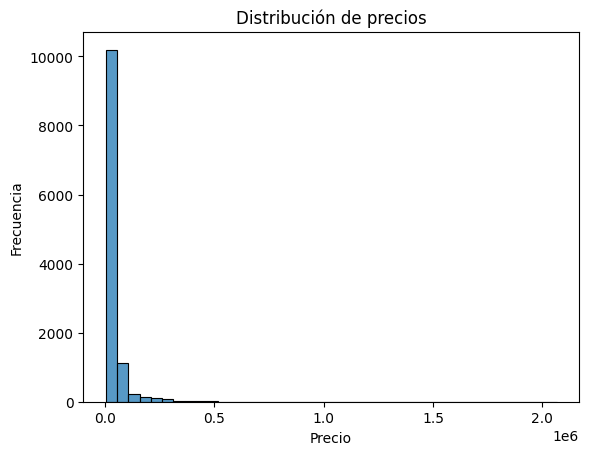

In [9]:
sns.histplot(data.msrp, bins = 40)
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.title('Distribución de precios')
plt.show()

Observamos de inmediato que la distribución de los precios muestra que existe una gran cantidad de autos de bajo precio y muy pocos con un valor alto. Hagamos un zoom tomando sólo los autos que cuesten menos de $100,000 USD.

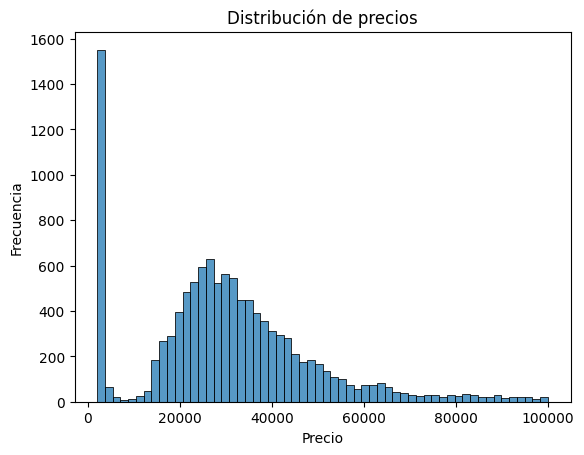

In [10]:
sns.histplot(data.msrp[data.msrp < 100000])
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.title('Distribución de precios')
plt.show()

Esta cola a la izquierda nos dificulta ver la distribución, pero más aún, puede llegar a confundir a los resultados del modelo, de tal forma que no aprenderá lo suficiente. 

Una forma sencilla de resolver este problema es utilizando una *transformación logarítmica*.

$$y_{\text{nuevo}} = \log (y + 1)$$

In [11]:
log_price = np.log1p(data['msrp'])

Veamos la nueva distribución de los datos logarítmicos.

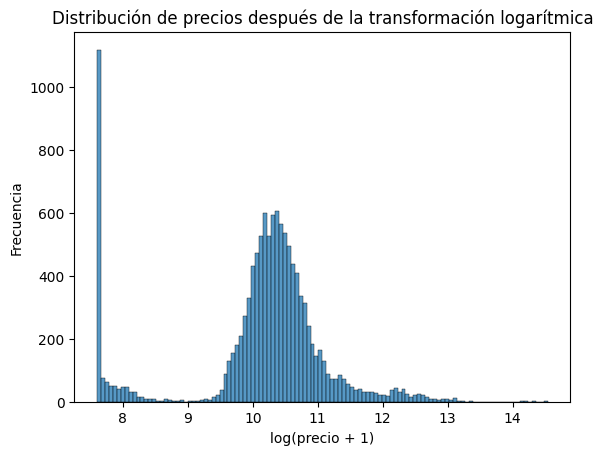

In [12]:
sns.histplot(log_price)
plt.xlabel('log(precio + 1)')
plt.ylabel('Frecuencia')
plt.title('Distribución de precios después de la transformación logarítmica')
plt.show()

Ahora sí, podemos observar que la distribución de los precios se asemeja a una campana. La distribución no es *normal*, debido a la presencia de la cola larga a en los precios más bajos, sin embargo el modelo puede lidiar con ello más fácilmente.

Ahora pasamos a otro punto importante en nuestro análisis exploratorio: buscar valores faltantes. Esto es necesario ya que ningún modelo de machine learning puede lidiar con valores nulos de manera automática. Debemos saber si necesitamos hacer algo especial para manejar dichos valores. 

Verificamos entonces si hay valores nulos en el dataset.

In [13]:
data.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

La buena noticia es que la columna `msrp` no tiene valores nulos. Podemos apreciar que la columna `market_category` tiene alrededor de 4000 datos faltantes. Más adelante veremos qué podemos hacer con estos datos.

## Validación

El siguiente paso es el establecer una estrategia de validación para garantizar que los modelos que entrenemos sean buenos y puedan generalizar. Es decir que el modelo pueda ser aplicado a nuevos datos nunca antes vistos por él. 

Para ello, utilizamos la *validación*. Necesitamos dividir al conjunto de datos en tres partes: *entrenamiento*, *validación* y *test*. Dividiremos los datos de la siguiente manera:

 - 20% de los datos serán para la validación.
 - 20% de los datos serán para el test.
 - 60% de los datos serán para el entrenamiento.



In [14]:
n = len(data) # número de columnas del dataframe

# Calculamos el número de datos a utilizar en cada etapa

n_val = int(0.2 * n)

n_test = int(0.2 * n)

n_train = n - (n_val + n_test)

In [15]:
print(f"Número de datos totales: {n}")
print(f"Número de datos para entrenamiento: {n_train}")
print(f"Número de datos para validación: {n_val}")
print(f"Número de datos para test: {n_test}")

Número de datos totales: 11914
Número de datos para entrenamiento: 7150
Número de datos para validación: 2382
Número de datos para test: 2382


Adicionalmente, vamos a mezclar el orden de los datos del dataframe:

In [16]:
np.random.seed(42) # Garantizamos reproducibilidad en nuestro proyecto

idx = np.arange(n) # Cramos un array de NumPy con los índices de la dataframe

np.random.shuffle(idx) # Lo revolvemos

data_shuffled = data.iloc[idx]

data_shuffled

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
3995,gmc,envoy_xl,2005,regular_unleaded,275.0,6.0,automatic,rear_wheel_drive,4.0,NaN,large,4dr_suv,18,13,549,29695
7474,volkswagen,passat,2016,regular_unleaded,170.0,4.0,automatic,front_wheel_drive,4.0,NaN,midsize,sedan,38,25,873,30495
7300,honda,odyssey,2016,regular_unleaded,248.0,6.0,automatic,front_wheel_drive,4.0,NaN,large,passenger_minivan,28,19,2202,37650
3148,chevrolet,cruze,2015,regular_unleaded,138.0,4.0,manual,front_wheel_drive,4.0,NaN,midsize,sedan,36,25,1385,16170
747,volvo,740,1991,regular_unleaded,162.0,4.0,automatic,rear_wheel_drive,4.0,"luxury,performance",midsize,sedan,20,17,870,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,toyota,venza,2014,regular_unleaded,181.0,4.0,automatic,front_wheel_drive,4.0,crossover,midsize,wagon,26,20,2031,27950
5191,pontiac,g6,2009,flex-fuel_(unleaded/e85),219.0,6.0,automatic,front_wheel_drive,4.0,flex_fuel,midsize,sedan,26,17,210,24710
5390,volkswagen,golf_gti,2016,premium_unleaded_(recommended),220.0,4.0,automated_manual,front_wheel_drive,2.0,"hatchback,performance",compact,2dr_hatchback,33,25,873,27590
860,saab,9-5,2009,premium_unleaded_(recommended),260.0,4.0,automatic,front_wheel_drive,4.0,"luxury,performance",midsize,wagon,27,17,376,43270


Dividimos el dataframe mezclado en los conjuntos de validación, test y entrenamiento.

In [17]:
data_train = data_shuffled.iloc[:n_train].copy()

data_val = data_shuffled.iloc[n_train:n_train + n_val].copy()

data_test = data_shuffled.iloc[n_train + n_val:].copy()

Ahora que el dataframe está dividido en tres partes, recordamos que nuestro análisis inicial sugirió aplicar una transformación logarítmica para deshacernos de la cola en la distribución de los precios, por lo que es conveniente aplicarla.

In [18]:
y_train = np.log1p(data_train.msrp.values)

y_val = np.log1p(data_val.msrp.values)

y_test = np.log1p(data_test.msrp.values)

Adicionalmente, para evitar utilizar la variable objetivo durante el entrenamiento del modelo, podemos remover la columna del dataframe.

In [19]:
del data_train['msrp']
del data_val['msrp']
del data_test['msrp']

## Machine Learning en problemas de regresión

Una vez que hemos hecho el análisis exploratorio de los datos y definido la estrategia de validación, estamos listos para entrenar un modelo. El problema que intentamos resolver es un *problema de regresión*: el objetivo es predecir un número, el precio de un auto. 

Por simplicidad, utilizaremos el modelo de regresión más simple: *regresión lineal*. 

Repasemos brevemente la idea detrás de la regresión lineal. De manera general, un modelo de machine learning supervisado tiene la forma:

$$ y \approx g(X) $$

donde $y$ es el vector de los valores que queremos predecir y $X$ es una matriz que contiene a las características de las observaciones. 

Para un solo registro, $y_i$ tenemos la relación $y_i \approx g(x_i)$. Si tenemos $n$ características, nuestro vector $x_i$ es $n$-dimensional, así que tiene $n$ componentes:

$$ x_i = (x_{i1}, x_{i2}, ..., x_{in})$$

Entonces, podemos escribir:

$$ y_i = g(x_i) = g(x_{i1}, x_{i2}, ..., x_{in})$$

En nuestro caso, tenemos 7150 autos en el conjunto de entrenamiento, $n = 7150$. Supongamos que $i=10$, tenemos el auto:

In [20]:
data_train.iloc[10]

make                            toyota
model                            yaris
year                              2015
engine_fuel_type      regular_unleaded
engine_hp                        106.0
engine_cylinders                   4.0
transmission_type               manual
driven_wheels        front_wheel_drive
number_of_doors                    2.0
market_category              hatchback
vehicle_size                   compact
vehicle_style            2dr_hatchback
highway_mpg                         37
city_mpg                            30
popularity                        2031
Name: 11815, dtype: object

Para mostrar la idea detrás de la regresión, escogemos algunas características numéricas e ignoramos el resto. Utilicemos `engine_hp`, `highway_mpg` y `popularity`.

Asignamos estas características como $x_{i1}$, $x_{i2}$ y $x_{i3}$, respectivamente:

$$ x_i = (x_{i1}, x_{i2}, x_{i3}) = (106, 37, 2031) $$

La idea es que al aplicar la función $g$ al vector $x_i$ el resultado sea lo más cercano posible al valor en la columna `msrp` para este auto.

Si $g$ es un modelo de regresión lineal, entonces tiene la siguiente forma general:

$$ g(x_i) = w_0 + x_{i1} w_1 + x_{i2} w_2 + \dots + x_{in} w_n $$

Las variables $w_0, w_1, w_2, ..., w_n$ son los parámetros del modelo. 

 - $w_0$ es el término umbral
 - $w_i$ son los *pesos* de cada característica $x_{in}$

Estos parámetros definen exactamente cómo el modelo debe combinar las características para que las predicciones al final sean tan cercanas al valor real como sea posible. 

En notación más compacta, tenemos:

$$ g(x_i) = w_0 + \sum_{j=1}^n x_{ij} w_j $$

Los valores de los pesos son lo que el modelo aprende cuando es entrenado. Pero, ¿cómo los obtenemos?

## Entrenamiento

El vector de pesos $w$ puede calcularse con la siguiente fórmula: 

$$ w = (X^T X)^{-1} X^T y $$

donde:

 - $X^T$ es la matriz transpuesta de $X$
 - $X^{-1}$ es la matriz inversa de $X$

Implementamos esta fórmula en NumPy:

In [21]:
def linear_regression(X, y):

    ones = np.ones(X.shape[0])

    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)

    XTX_inv = np.linalg.inv(XTX)

    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

Para poder utilizar este código necesitamos una matriz $X$ de características y un vector $y$ de la variable objetivo. Vamos a construir la matriz de características a partir de los datos de la dataframe. 

Comenzaremos con una forma sencilla: seleccionamos algunas características numéricas de la dataframe y con ellas creamos la matriz $X$. En el ejemplo anterior utilizamos sólo algunos, pero ahora utilizaremos:

 - `engine_hp`, `engine_cylinders`, `highway_mpg`, `city_mpg`, y `popularity`.

In [22]:
features = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

data_num = data_train[features]

In [23]:
data_num.head()

,engine_hp,engine_cylinders,highway_mpg,city_mpg,popularity
3995,275.0,6.0,18,13,549
7474,170.0,4.0,38,25,873
7300,248.0,6.0,28,19,2202
3148,138.0,4.0,36,25,1385
747,162.0,4.0,20,17,870


Recordemos que algunas de estas columnas contienen valores nulos. Necesitamos hacer algo al respecto, ya que el modelo de regresión lineal no puede lidiar con este tipo de datos.

Una opción es deshacernos de todas las filas que contengan al menos un valor nulo. Sin embargo, la desventaja es que perderemos la información de las columnas restantes. La otra opción es llenar estos datos con otros valores. La forma más común de hacerlo es llenando los valores faltantes con ceros.

In [24]:
data_num = data_num.fillna(0)

Inspeccionamos rápidamente que no tenemos valores nulos.

In [25]:
data_num.isnull().sum()

engine_hp           0
engine_cylinders    0
highway_mpg         0
city_mpg            0
popularity          0
dtype: int64

Ahora convertimos la dataframe a un array de NumPy, utilizando la propiedad `values`.

In [26]:
X_train = data_num.values

X_train

array([[ 275.,    6.,   18.,   13.,  549.],
       [ 170.,    4.,   38.,   25.,  873.],
       [ 248.,    6.,   28.,   19., 2202.],
       ...,
       [ 150.,    4.,   24.,   17., 1851.],
       [ 160.,    4.,   31.,   22.,  204.],
       [ 274.,    4.,   27.,   17., 1439.]])

Aplicamos la función que definimos para hacer la regresión lineal:

In [27]:
w_0, w = linear_regression(X_train, y_train)

## Evaluación del modelo

Una vez entrenado el modelo, podemos aplicarlo a los datos de entrenamiento para ver qué tan bien predice.

In [28]:
y_pred = w_0 + X_train.dot(w)

Utilizamos un histograma para ver qué tan buenas son las predicciones respecto a los valores reales.

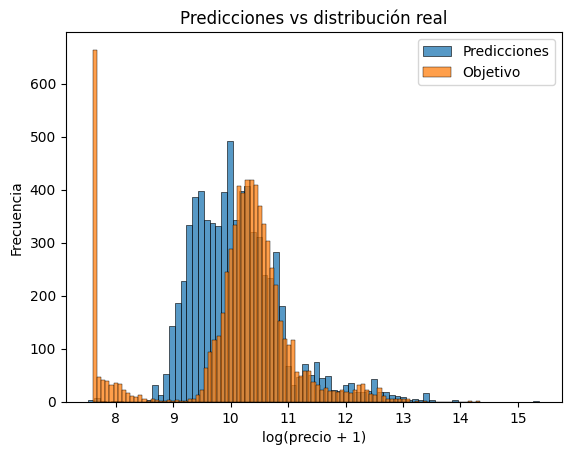

In [29]:
sns.histplot(y_pred, label = 'Predicciones')
sns.histplot(y_train, label = 'Objetivo')
plt.xlabel('log(precio + 1)')
plt.ylabel('Frecuencia')
plt.title('Predicciones vs distribución real')
plt.legend()
plt.show()

Podemos observar que al comparar las distribuciones de la variable objetivo y las predicciones generadas por el modelo, las predicciones no son tan cercanas a los valores reales. Pensamos entonces en utilizar una métrica que cuantifique la calidad de nuestro modelo. Una de las más utilizadas es el *error cuadrático medio* (*root mean squared error (RMSE)*).

El RMSE nos dice qué tan alejadas están nuestras predicciones respecto a los objetivos verdaderos. Se calcula como:

$$ \text{RMSE} = \sqrt{\frac{1}{m} \sum_{i=1}^m \left( g(x_i) - y_i \right)^2 } $$

In [30]:
def rmse(y,y_pred):

    error = y_pred - y

    mse = (error**2).mean()

    return np.sqrt(mse)

Al aplicarlo en nuestros resultados, obtenemos:

In [31]:
error_modelo = rmse(y_train, y_pred)

print(F"El error cuadrático medio del modelo, con los datos de entrenamiento, es de: {np.round(error_modelo, 3)}")

El error cuadrático medio del modelo, con los datos de entrenamiento, es de: 0.757


Es decir, que en promedio, las predicciones del modelo se alejan del valor real en **0.75**. La ventaja de utilizar este tipo de métricas está en que podemos generar otros modelos y comparar qué tan bueno es para predecir.

## Validación del modelo

A pesar de este resultado, no refleja el hecho de que el propósito del modelo es que logre predecir el precio de autos que no ha visto antes. Para eso se utiliza el conjunto de validación. 

Anteriormente creamos una matriz `X_train` a partir del data frame `data_train` y la utilizamos para entrenar el modelo. Un procedimiento similar es necesario para obtener una matriz del data frame de validación, `X_val`.

In [32]:
data_num_val = data_val[features]

data_num_val = data_num_val.fillna(0)

X_val = data_num_val.values

Aplicamos el modelo a `X_val` para obtener predicciones:

In [33]:
y_pred_val = w_0 + X_val.dot(w)

El array `y_pred_val` contiene predicciones para el conjunto de validación. Ahora podemos utilizarlo y compararlo con los precios reales en `y_val`, utilizando la función RMSE que definimos anteriormente.

In [34]:
error_val = rmse(y_val, y_pred_val)

print(F"El error cuadrático medio del modelo, con los datos de validación, es de: {np.round(error_modelo, 2)}")

El error cuadrático medio del modelo, con los datos de validación, es de: 0.76


Este valor es el número que debemos tomar en cuenta para comparar los modelos. 

Otra cosa que puede mejorar nuestro flujo de trabajo es crear una función que prepare los datos $X$ a partir de la dataframe.

In [35]:
def data_prepare_X(dataframe):

    df_num = dataframe[features]

    df_num = df_num.fillna(0)

    X = df_num.values

    return X

Entonces, el proceso de entrenamiento y evaluación puede ser ejecutado como:

        X_train = data_prepare_X(data_train)
        w_0, w = linear_regression(X_train, y_train)

        X_val = data_prepare_X(data_val)
        y_pred = w_0 + X_val.dot(w)
        print("Validación: ", rmse(y_val, y_pred))

## Feature engineering

Para mejorar el desempeño de nuestro modelo, podemos añadir más características, creandolas y añadiéndolas a los atributos ya existentes. Este proceso se conoce como *feature engineering*.

Nuestro objetivo es mejorar el valor del RMSE calculado para los datos de validación. Veamos cómo podemos añadir características. Pensemos por ejemplo en la característica `age`, que puede obtenerse a partir de la columna `year`. La edad del auto debería ser útil al momento de calcular su precio, ya que de forma intuitiva, mientras más reciente sea un auto, más caro será.

Veamos cómo crearla.

In [36]:
data.year.max()

2017

Notamos que los registros más nuevos de los autos corresponden al año 2017, entonces podemos calcular la edad del auto al restar el año de manufactura del año 2017.

In [37]:
data_train['age'] = 2017 - data_train.year

data_train['age']

3995     12
7474      1
7300      1
3148      2
747      26
         ..
10845    14
4861      2
2334     11
8651     12
5246      3
Name: age, Length: 7150, dtype: int64

Añadimos la implementación de la nueva variable `age`a nuestra función de preparación de los datos.

In [38]:
def data_prepare_X(dataframe):

    dataframe = dataframe.copy()

    feats = features.copy()

    dataframe['age'] = dataframe.year.max() - dataframe.year

    feats.append('age')

    df_num = dataframe[feats]
    df_num = df_num.fillna(0)

    X = df_num.values

    return X

Veamos si añadir la característica `age` nos lleva a alguna mejora del modelo:

In [39]:
X_train = data_prepare_X(data_train)

w_0, w = linear_regression(X_train, y_train)

In [40]:
X_val = data_prepare_X(data_val)

y_pred = w_0 + X_val.dot(w)

print("Validación: ", np.round(rmse(y_val, y_pred),3))

Validación:  0.513


Podemos observar que el error de validación es de **0.51**, lo que representa una mejora considerable respecto al resultado anterior de **0.76**. Entonces, es claro que añadir la variable `age` es útil para hacer las predicciones. Veamos también la distribución de los valores predichos.

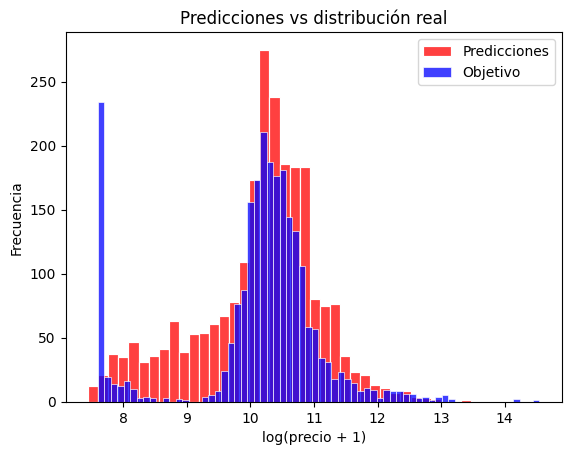

In [41]:
sns.histplot(y_pred, label = 'Predicciones', color = 'red', edgecolor = 'white')
sns.histplot(y_val, label = 'Objetivo', color = 'blue', edgecolor = 'white')
plt.xlabel('log(precio + 1)')
plt.ylabel('Frecuencia')
plt.title('Predicciones vs distribución real')
plt.legend()
plt.show()

Es claro que la distribución de las predicciones se aproxima aún mejor a la distribución de los objetivos. Esto también es confirmado por el valor del RMSE.

## Variables categóricas

Como tuvimos éxito al añadir la variable `age` podríamos echar un vistazo al resto de las variables para ver si también tienen influencia en la predicción. Una de las columnas que podríamos utilizar sería el número de puertas. Esta variable podría parecer numérica, ya que puede tomar los valores de 2, 3 o 4 puertas. Sin embargo, no es una variable numérica, ya que no podríamos decir que al añadir una puerta el precio incrementa o disminuye. Esta variable es una *variable categórica*, y este tipo de variables describen las características del objeto y pueden tomar ciertos valores. 

Por ejemplo, la marca del auto es una categoría, podría ser Toyota, BMW, Ford, etc. Las variables categóricas generalmente no son números sino strings. Para el caso de las puertas, podemos codificarlas en un conjunto de valores binarios. Primero veamos cuáles son todos los posibles valores que puede tomar la variable `number_of_doors`.

In [42]:
data_train.number_of_doors.unique()

array([ 4.,  2.,  3., nan])

Exceptuando el valor `nan`, tenemos tres posibles valores: `2, 3, 4`. Creamos entonces tres características binarias: `num_doors_2`, `num_doors_3` y `num_doors_4`. Si el auto resulta tener 2 puertas, `num_doors_2` tendrá el valor de 1, y el resto serán 0. Si el coche tiene 3 puertas, `num_doors_3` será igual a 1 y el resto serán 0, y lo mismo para la variable `num_doors_4`.

Este método de codificación de variables se conoce como `one-hot encoding`. ¿Cómo se hace? Primero tenemos que determinar si la fila de nuestra columna es igual a uno de los posibles valores de la categoría. Para ello podemos recurrir al operador de comparación `==`. Aplicado sobre una serie, iterará sobre cada elemento de la columna, comparandolo sobre la lista de posibles valores y devolviendo un valor booleano de `True` si coinciden y `False` si no lo hacen.


<center>
    <figure>
    <img src = "img/one-hot.png" alt="One-hot encoding de variables categóricas" style="width:600px;height:450px;">
    <figcaption> One-hot encoding de variables categóricas. </figcaption>
    </figure>
</center>

Esta operación genera distintas series para los valores de $i = 2,3,4$. Posteriormente, para incluirlos en los datos de entrenamiento y validación, es necesario convertir esos valores booleanos a enteros para que Python pueda realizar las operaciones matriciales. Esto se logra fácilmente con la función `astype(int)`.

<center>
    <figure>
    <img src = "img/astype.png"  style="width:800px;height:350px;">
    <figcaption> Conversión de valores booleanos a enteros. </figcaption>
    </figure>
</center>

Esta codificación puede aplicarse a otras variables categóricas, no necesariamente numéricas. Consideremos, por ejemplo, la característica `make`.  Veamos qué posibles valores tenemos:

In [43]:
data.make.unique()

array(['bmw', 'audi', 'fiat', 'mercedes-benz', 'chrysler', 'nissan',
       'volvo', 'mazda', 'mitsubishi', 'ferrari', 'alfa_romeo', 'toyota',
       'mclaren', 'maybach', 'pontiac', 'porsche', 'saab', 'gmc',
       'hyundai', 'plymouth', 'honda', 'oldsmobile', 'suzuki', 'ford',
       'cadillac', 'kia', 'bentley', 'chevrolet', 'dodge', 'lamborghini',
       'lincoln', 'subaru', 'volkswagen', 'spyker', 'buick', 'acura',
       'rolls-royce', 'maserati', 'lexus', 'aston_martin', 'land_rover',
       'lotus', 'infiniti', 'scion', 'genesis', 'hummer', 'tesla',
       'bugatti'], dtype=object)

Tenemos una buena cantidad de marcas de automóviles, pero por simplicidad, tomaremos las 10 marcas con mayor frecuencia en nuestros datos.

In [44]:
data['make'].value_counts().head(10)

make
chevrolet     1123
ford           881
volkswagen     809
toyota         746
dodge          626
nissan         558
gmc            515
honda          449
mazda          423
cadillac       397
Name: count, dtype: int64

La idea es generar una codificación *one-hot* para las marcas igual que para el número de puertas. Añadimos estos pasos a nuestra función de preparación de los datos, `data_prepare_X`.

In [45]:
def data_prepare_X(dataframe):

    dataframe = dataframe.copy()

    feats = features.copy()

    dataframe['age'] = dataframe.year.max() - dataframe.year

    feats.append('age')

    # One-hot encoding para el número de puertas

    for i in [2,3,4]: # Lista de posibles valores del número de puertas

        feature = 'num_doors_%s' % i # Durante cada iteración, se crea una string para el número de puertas, el operador % inserta el valor de i de la lista
        
        dataframe[feature] = (dataframe['number_of_doors'] == i).astype(int) # Se crea la columna de num_doors_i y se convierten a enteros

        feats.append(feature) # Se añaden las características al dataframe

    # One-hot encoding para los fabricantes de autos

    top_makers = dataframe['make'].value_counts().head(10).index.tolist() # Primero, creamos la lista con los 10 fabricantes más populares en la base de datos

    for k in top_makers:

        feature = 'is_make_%s' % k
        
        dataframe[feature] = (dataframe['make'] == k).astype(int)

        feats.append(feature)


    df_num = dataframe[feats]
    df_num = df_num.fillna(0)

    X = df_num.values

    return X

Veamos si estos cambios mejoran el RMSE del modelo.

In [46]:
X_train = data_prepare_X(data_train)

w_0, w = linear_regression(X_train, y_train)

X_val = data_prepare_X(data_val)

y_pred = w_0 + X_val.dot(w)

print('Validación: ', np.round(rmse(y_val, y_pred), 3))

Validación:  0.493


El valor del RMSE tras codificar la variable `make` y añadirla al modelo de regresión lineal, nos dice que mejora de **0.51** a **0.49**. Lo que nos indica que podríamos ir añadiendo más variables para mejorar los resultados. ¿Será cierto? Hagámoslo, y añadiremos `engine_fuel_type`, `transmission_type`, `driven_wheels`, `market_category`, `vehicle_size` y `vehicle_style`.

Primero es necesario explorar cada una de las categorías. La idea es mantener un modelo no tan complejo.

In [47]:
engine = data_train['engine_fuel_type'].unique().tolist()

engine

['regular_unleaded',
 'premium_unleaded_(recommended)',
 'premium_unleaded_(required)',
 'flex-fuel_(unleaded/e85)',
 'diesel',
 'electric',
 'flex-fuel_(premium_unleaded_required/e85)',
 'flex-fuel_(premium_unleaded_recommended/e85)',
 'flex-fuel_(unleaded/natural_gas)',
 nan]

Tenemos varias categorías para el tipo de combustible, así que como en el caso de las marcas, nos quedaremos con las 5 más frecuentes.

In [48]:
engine = data_train['engine_fuel_type'].value_counts().head(5).index.tolist()

engine

['regular_unleaded',
 'premium_unleaded_(required)',
 'premium_unleaded_(recommended)',
 'flex-fuel_(unleaded/e85)',
 'diesel']

In [49]:
transmission = data_train['transmission_type'].unique().tolist()

transmission

['automatic', 'manual', 'automated_manual', 'direct_drive', 'unknown']

Para el caso del tipo de transmisión, la categoría `unkown` no es útil, por lo que no la consideraremos.

In [50]:
transmission = [t for t in data_train['transmission_type'].unique().tolist() if t != 'unknown']

transmission

['automatic', 'manual', 'automated_manual', 'direct_drive']

In [51]:
traction = data_train['driven_wheels'].unique().tolist()

traction

['rear_wheel_drive',
 'front_wheel_drive',
 'all_wheel_drive',
 'four_wheel_drive']

In [52]:
market = data_train['market_category'].unique().tolist()

market

[nan,
 'luxury,performance',
 'crossover',
 'hatchback',
 'factory_tuner,performance',
 'performance',
 'hatchback,factory_tuner,luxury,performance',
 'flex_fuel',
 'exotic,luxury,high-performance',
 'factory_tuner,high-performance',
 'luxury',
 'hatchback,performance',
 'crossover,luxury',
 'hatchback,hybrid',
 'crossover,luxury,diesel',
 'exotic,luxury,performance',
 'crossover,hatchback',
 'flex_fuel,performance',
 'flex_fuel,hybrid',
 'hybrid',
 'luxury,high-performance',
 'diesel',
 'crossover,flex_fuel',
 'flex_fuel,luxury,high-performance',
 'high-performance',
 'crossover,factory_tuner,luxury,high-performance',
 'flex_fuel,luxury',
 'exotic,high-performance',
 'luxury,hybrid',
 'hatchback,luxury',
 'crossover,luxury,hybrid',
 'factory_tuner,luxury,high-performance',
 'exotic,factory_tuner,luxury,high-performance',
 'exotic,factory_tuner,high-performance',
 'crossover,factory_tuner,luxury,performance',
 'hatchback,luxury,performance',
 'factory_tuner,luxury,performance',
 'cross

También tenemos una gran cantidad de valores para el mercado del auto, nos quedamos con las 5 más frecuentes.

In [53]:
market = data_train['market_category'].value_counts().head(5).index.tolist()

market

['crossover', 'flex_fuel', 'luxury', 'luxury,performance', 'hatchback']

In [54]:
size = data_train['vehicle_size'].unique().tolist()

size

['large', 'midsize', 'compact']

Las categorías del tamaño del vehículo no representan problema alguno, así que tomaremos todas.

In [55]:
style = data_train['vehicle_style'].unique().tolist()

style

['4dr_suv',
 'sedan',
 'passenger_minivan',
 'extended_cab_pickup',
 'wagon',
 'coupe',
 '2dr_hatchback',
 'regular_cab_pickup',
 '4dr_hatchback',
 'crew_cab_pickup',
 'cargo_van',
 'passenger_van',
 '2dr_suv',
 'convertible',
 'cargo_minivan',
 'convertible_suv']

In [56]:
style = data_train['vehicle_style'].value_counts().head(5).index.tolist()

style 

['sedan', '4dr_suv', 'coupe', 'convertible', '4dr_hatchback']

Finalmente, para el estilo, tomaremos las primeras 5 más frecuentes.

Añadimos estas categorías y las codificamos.

In [57]:
def data_prepare_X(dataframe):

    dataframe = dataframe.copy()

    feats = features.copy()

    dataframe['age'] = dataframe.year.max() - dataframe.year

    feats.append('age')

    # One-hot encoding para el número de puertas

    for i in [2,3,4]: # Lista de posibles valores del número de puertas

        feature = 'num_doors_%s' % i # Durante cada iteración, se crea una string para el número de puertas, el operador % inserta el valor de i de la lista
        
        dataframe[feature] = (dataframe['number_of_doors'] == i).astype(int) # Se crea la columna de num_doors_i y se convierten a enteros

        feats.append(feature) # Se añaden las características al dataframe

    # One-hot encoding para los fabricantes de autos

    top_makers = dataframe['make'].value_counts().head(10).index.tolist() # Primero, creamos la lista con los 10 fabricantes más populares en la base de datos

    for k in top_makers:

        feature = 'is_make_%s' % k
        
        dataframe[feature] = (dataframe['make'] == k).astype(int)

        feats.append(feature)

    # One-hot encoding para tipo de combustible

    for v in engine:

        feature = 'is_type_%s' %v

        dataframe[feature] = (dataframe['engine_fuel_type'] == v).astype(int)

        feats.append(feature)

    # One-hot encoding para tipo de transmisión

    for v in transmission:

        feature = 'is_transmission_%s' %v

        dataframe[feature] = (dataframe['transmission_type'] == v).astype(int)

        feats.append(feature)

    # One-hot encoding para tipo de tracción

    for v in traction:

        feature = 'is_driven_wheels_%s' %v

        dataframe[feature] = (dataframe['driven_wheels'] == v).astype(int)

        feats.append(feature)

    # One-hot encoding para categoría de mercado

    for v in market:

        feature = 'is_mc_%s' %v

        dataframe[feature] = (dataframe['market_category'] == v).astype(int)

        feats.append(feature)

    # One-hot encoding para tamaño de vehículo

    for v in size:

        feature = 'is_size_%s' %v

        dataframe[feature] = (dataframe['vehicle_size'] == v).astype(int)

        feats.append(feature)

    # One-hot encoding para estilo de vehículo

    for v in style:

        feature = 'is_style_%s' %v 

        dataframe[feature] = (dataframe['vehicle_style'] == v).astype(int)

        feats.append(feature)

    df_num = dataframe[feats]
    df_num = df_num.fillna(0)

    X = df_num.values

    return X

Probemos el modelo.

In [58]:
X_train = data_prepare_X(data_train)

w_0, w = linear_regression(X_train, y_train)

X_val= data_prepare_X(data_val)

y_pred = w_0 + X_val.dot(w)

print('Validación: ', np.round(rmse(y_val, y_pred), 3))

Validación:  218.139


¡Vaya! El valor de la validación es de **73.75**. En vez de ayudarnos, las características añadidas empeoraron el puntaje del RMSE. Sin embargo, no todo está perdido, veamos qué podemos hacer ante esta situación.

## Regularización

¿Por qué el añadir más características empeoró el desempeño de nuestro modelo? Bueno, la razón tiene que ver con la inestabilidad numérica del método de resolución. Recordemos la ecuación:

$$ w = \left(X^T X \right)^{-1} X^T y $$

El primer factor es la inversa de la matriz $X^T X$, en este caso el problema reside en la inversión de esa matriz. En ocasiones, al añadir nuevas columnas a $X$ podemos, accidentalmente, incluir una columna que resulta ser una combinación de otras columnas. 

Cuando esto ocurre, $X^T X$ se vuelve *indeterminada*, o *singular*, lo que implica que no es posible encontrar la inversa de esa matriz. Otro de los motivos es que generalmente las columnas no son una combinación lineal exacta de las otras columnas. Los datos reales a menudo son ruidosos, con errores de medición. Es por estas razones que algunos de los valores en los pesos $w$ se vuelven mucho más grandes de lo que deberían. 

Veamos qué valores tenemos.

In [59]:
print(f'El valor de w0 es: {w_0}')
print(f'El valor máximo del vector w es de: {max(w)}')
print(f'El valor mínimo del vector w es de: {min(w)}')

El valor de w0 es: 1.4131331354293618e+16
El valor máximo del vector w es de: 6855.632535344352
El valor mínimo del vector w es de: -1.4131331354301116e+16


En álgebra lineal, estos problemas se conocen como *problemas de inestabilidad numérica*, y generalmente se pueden remendar utilizando técnicas de regularización. El objetivo de la *regularización* es el asegurarse de que la matriz inversa exista, al forzar que la matriz sea invertible. En el contexto del machine learning, significa controlar los valores de los pesos del modelo para que se comporten correctamente y no alcancen valores extremos.

Una forma de aplicar regularización es añadir un pequeño número a cada elemento diagonal de la matriz. La fórmula para regresión lineal es entonces:

$$ w = \left( X^T X + \alpha I \right)^{-1} X^T y $$

Podemos traducir esta expresión a Python utilizando NumPy. Supongamos que tenemos una matriz $X^T X$, podemos crear una matriz identidad y sumarla para ver el efecto que genera sobre la diagonal principal.

In [60]:
XTX = np.array([
    [0, 1, 2, 3],
    [3, 4, 5, 0],
    [0, 2, 2, 1],
    [1, 6, 2, 3]
])

print(XTX)

[[0 1 2 3]
 [3 4 5 0]
 [0 2 2 1]
 [1 6 2 3]]


In [61]:
I = np.eye(4)

print(I)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [62]:
alpha = 0.01

alpha * I

array([[0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.01]])

In [63]:
XTX + alpha * I 

array([[0.01, 1.  , 2.  , 3.  ],
       [3.  , 4.01, 5.  , 0.  ],
       [0.  , 2.  , 2.01, 1.  ],
       [1.  , 6.  , 2.  , 3.01]])

Entonces, es conveniente re definir nuestra función que ejecuta el algoritmo de regresión lineal para incluir esta idea.

In [64]:
def linear_regression(X, y, r = 0.0):

    ones = np.ones(X.shape[0])

    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)

    reg = r * np.eye(XTX.shape[0])

    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)

    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:] 

Veamos cómo se comporta para ciertos valores de `r`.

In [65]:
for r in [0., 0.001, 0.01, 0.1, 1, 10]:

    w_0, w = linear_regression(X_train, y_train, r = r)

    print(f"Para r = {r}, se tienen: w_0 = {np.round(w_0,2)}, w_13 = {np.round(w[13],2)}, w_21 = {np.round(w[21],2)}")

Para r = 0.0, se tienen: w_0 = 1.413133135429362e+16, w_13 = 5.88, w_21 = 82.15
Para r = 0.001, se tienen: w_0 = 6.65, w_13 = -0.14, w_21 = -0.28
Para r = 0.01, se tienen: w_0 = 6.64, w_13 = -0.14, w_21 = -0.28
Para r = 0.1, se tienen: w_0 = 6.49, w_13 = -0.14, w_21 = -0.27
Para r = 1, se tienen: w_0 = 5.71, w_13 = -0.14, w_21 = -0.21
Para r = 10, se tienen: w_0 = 4.31, w_13 = -0.12, w_21 = 0.16


Observemos que cuando el término de regularización es 0, obtenemos valores extremos para los pesos. Sin embargo, conforme vamos aumentando el valor de `r`, los pesos van disminuyendo. 

Supongamos que tomamos a `r = 0.001`, veamos cuál es el RMSE en este caso.

In [66]:
X_train = data_prepare_X(data_train)

w_0, w = linear_regression(X_train, y_train, r = 0.001)

X_val = data_prepare_X(data_val)

y_pred = w_0 + X_val.dot(w)

print("Validación con regularización: ", np.round(rmse(y_val, y_pred),3))

Validación con regularización:  0.457


Notemos que ahora tenemos un modelo que incluye más características y que además está regularizado. Nos arroja un valor del RMSE de **0.45**, el cual es una mejora del modelo anterior con **0.49**.

Recordemos que utilizamos `r = 0.001`, pero ¿qué tal si existe otro valor de `r` que mejora aún más nuestro modelo? Hagamos más pruebas con distintos valores para tratar de encontrarlo.

In [67]:
for r in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20]:

    w_0, w = linear_regression(X_train, y_train, r = r)

    y_pred = w_0 + X_val.dot(w)

    print(f"Para r = {r}, el valor del RMSE es de: {np.round(rmse(y_val, y_pred), 6)}")

Para r = 1e-05, el valor del RMSE es de: 0.456653
Para r = 0.0001, el valor del RMSE es de: 0.456653
Para r = 0.001, el valor del RMSE es de: 0.456652
Para r = 0.01, el valor del RMSE es de: 0.456646
Para r = 0.1, el valor del RMSE es de: 0.456631
Para r = 1, el valor del RMSE es de: 0.457577
Para r = 5, el valor del RMSE es de: 0.462155
Para r = 10, el valor del RMSE es de: 0.468544
Para r = 20, el valor del RMSE es de: 0.481303


Es claro que para valores de r < 0.1, no se muestran cambios significativos en el RMSE, y que el valor de regularización que mejor resultado obtuvo es el de `r = 0.01`. 

Usémoslo para el modelo final, y comparemos con el conjunto de datos de prueba para verificar si el modelo funciona.

In [68]:
X_train= data_prepare_X(data_train)

w_0, w = linear_regression(X_train, y_train, r = 0.01)

X_val = data_prepare_X(data_val)

y_pred = w_0 + X_val.dot(w)

print("Validación del modelo final: ", np.round(rmse(y_val, y_pred), 3))

X_test = data_prepare_X(data_test)

y_pred = w_0 + X_test.dot(w)

print("Score con el data test: ", np.round(rmse(y_test, y_pred),3))

Validación del modelo final:  0.457
Score con el data test:  0.452


Estos números son muy cercanos, por lo que se puede concluir que el modelo puede generalizar bien con datos no antes vistos.

## Resultados

Veamos cómo se comporta nuestro modelo. Tomemos unos cuantos valores del conjunto de prueba.

In [85]:
test_1 = data_test.iloc[30:50]

Aplicamos la función de transformación de datos para ingresarlos al modelo y generamos las predicciones.

In [86]:
X_test_1 = data_prepare_X(test_1)

y_pred_test_1 = w_0 + X_test_1.dot(w)


Grafiquemos los resultados obtenidos.

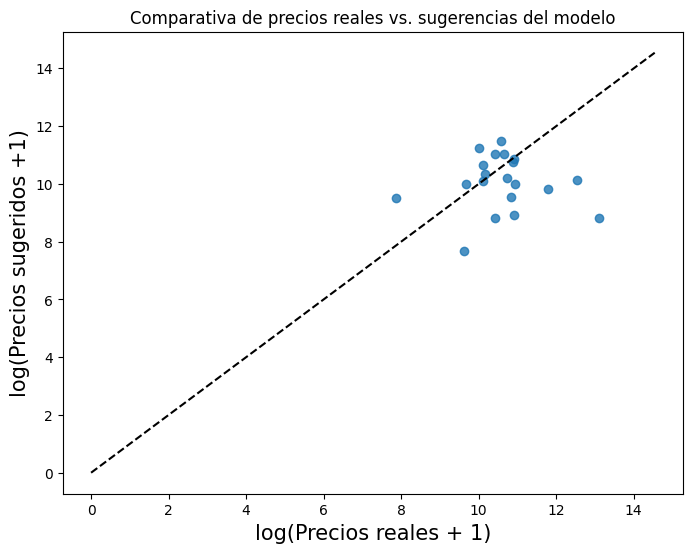

In [91]:
fig, ax = plt.subplots(1, 1, figsize = (8,6), dpi = 100)
ax.scatter(y_val[30:50], y_pred_test_1, alpha = 0.8)
max_price = max(y_val.max(), y_pred_test_1.max())
ax.plot([0, max_price], [0, max_price], 'k--', lw = 1.5)
ax.set_xlabel('log(Precios reales + 1)', fontsize = 15)
ax.set_ylabel('log(Precios sugeridos +1)', fontsize = 15)
ax.set_title('Comparativa de precios reales vs. sugerencias del modelo')
plt.show()

Recordemos que hicimos una transformación logarítmica a los datos de los precios, así que para obtener los precios aplicamos la función exponencial.

In [87]:
real_prices = np.expm1(y_val[30:50])

suggested_prices = np.expm1(y_pred_test_1)


Generamos una gráfica de dispersión de los precios reales vs los precios sugeridos. La línea discontinua representa los puntos donde el precio sugerido es igual al precio real. Si un punto cae sobre esta línea significa que la predicción fue correcta. Cuando más cercaestén los puntos de esta línea, mas precisas son las predicciones.

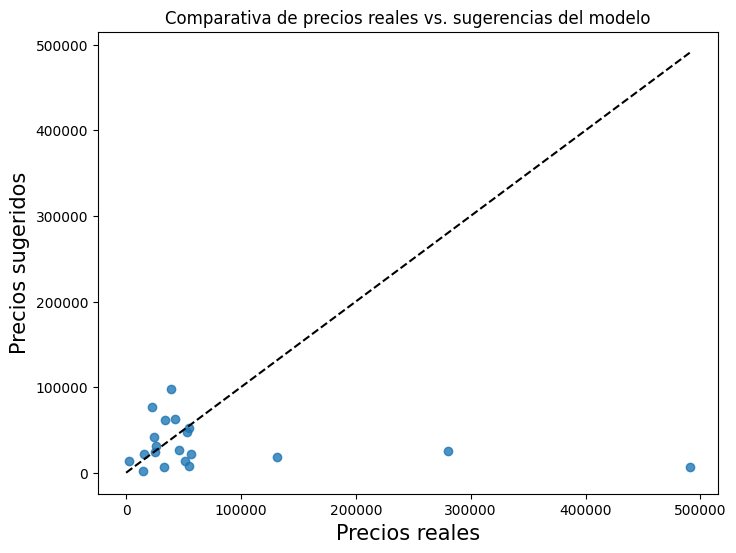

In [92]:
fig, ax = plt.subplots(1, 1, figsize = (8,6), dpi = 100)
ax.scatter(real_prices, suggested_prices, alpha = 0.8)
max_price = max(real_prices.max(), suggested_prices.max())
ax.plot([0, max_price], [0, max_price], 'k--', lw = 1.5)
ax.set_xlabel('Precios reales', fontsize = 15)
ax.set_ylabel('Precios sugeridos', fontsize = 15)
ax.set_title('Comparativa de precios reales vs. sugerencias del modelo')

plt.show()

Poniéndolo en ejemplos concretos:

In [100]:
print(f"El precio real del auto {test_1.iloc[0].make} {test_1.iloc[0].model} modelo {test_1.iloc[0].year} es de ${np.round(real_prices[0],2)}")
print(f"Mientras que el precio sugerido por nuestro modelo para ese mismo auto es de ${np.round(suggested_prices[0],2)}")

El precio real del auto gmc canyon modelo 2015 es de $55070.0
Mientras que el precio sugerido por nuestro modelo para ese mismo auto es de $51963.09


In [102]:
print(f"El precio real del auto {test_1.iloc[5].make} {test_1.iloc[5].model} modelo {test_1.iloc[5].year} es de ${np.round(real_prices[5],2)}")
print(f"Mientras que el precio sugerido por nuestro modelo para ese mismo auto es de ${np.round(suggested_prices[5],2)}")

El precio real del auto gmc sierra_1500_hybrid modelo 2013 es de $52780.0
Mientras que el precio sugerido por nuestro modelo para ese mismo auto es de $47409.86


## Conclusiones

 - El análisis exploratorio de datos inicial es de suma importancia. Nos ayuda a encontrar si los datos tienen valores faltantes. Ya que para un modelo de regresión lineal es imposible entrenar con valores nulos.

 - Una parte importante de la exploración inicial de los datos es el revisar la distribución de la variable objetivo. Si la distribución presenta colas largas, es necesario aplicar una transformación logaritmo. Sin ella, podríamos obtener resultados inadecuados.

 - Una de las mejores prácticas en modelos de aprendizaje automático es la separación de los conjuntos de entrenamiento, validación y prueba para revisar el desempeño del modelo.

 - Las métricas de evaluación, como el error cuadrático medio, RMSE, nos da una manera de medir el desempeño de predicción de nuestro modelo sobre el conjunto de validación. Lo que nos ayuda a confirmar si el modelo es adecuado y además nos apoya para comparar distintos modelos para así encontrar el mejor.

 - La ingeniería de características (feature engineering) es el proceso de crear nuevas características. Añadir estas características tiene un grado de importancia para mejorar el desempeño del modelo. Al añadirlas, siempre tenemos que utilizar el conjunto de validación para garantizar que en efecto nuestro modelo mejora.

 - En ocasiones se presentarán problemas de inestabilidad numérica, los cuales pueden resolverse con técnicas de regularización.

 - Después de que el modelo es entrenado y validado, podemos utilizarlo para hacer predicciones.